In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random

/mnt/e/workspace/townhall/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define message class to encapsulate information shared by agents

In [2]:
class Message:
    def __init__(self, sender_id, position, perceived_distances):
        self.sender_id = sender_id
        self.position = position
        self.perceived_distances = perceived_distances

Extend the CooperativeAgent class

In [3]:
class CooperativeAgent:
    def __init__(self, id, grid_size, num_features):
        self.id = id
        self.grid_size = grid_size
        self.position = (random.randint(0, self.grid_size - 1),
                         random.randint(0, self.grid_size - 1))
        self.positions = [self.position]
        self.messages = []  # Store received messages
    def send_message(self, targets):
        perceived_distances = [((self.position[0] - target[0]) ** 2 +
                                (self.position[1] - target[1]) ** 2) ** 0.5 for target in targets]
        return Message(self.id, self.position, perceived_distances)
    def receive_messages(self, messages):
        self.messages = messages
    def take_action(self, targets):
        closest_target_distances = [float('inf')] * len(targets)
        for message in self.messages:
            for i, distance in enumerate(message.perceived_distances):
                closest_target_distances[i] = min(
                    closest_target_distances[i], distance)
        my_distances = [((self.position[0] - target[0]) ** 2 +
                         (self.position[1] - target[1]) ** 2) ** 0.5 for target in targets]
        target_priorities = [my_distance if my_distance <= closest_target_distance else float('inf')
                             for my_distance, closest_target_distance in zip(my_distances, closest_target_distances)]
        chosen_target_index = target_priorities.index(min(target_priorities))
        chosen_target = targets[chosen_target_index]
        new_position = (
            self.position[0] + np.sign(chosen_target[0] - self.position[0]),
            self.position[1] + np.sign(chosen_target[1] - self.position[1])
        )
        self.position = new_position
        self.positions.append(new_position)
    def calculate_reward(self, targets):
        reward = 0
        for target in targets:
            old_distance = ((self.positions[-2][0] - target[0]) **
                            2 + (self.positions[-2][1] - target[1]) ** 2) ** 0.5
            new_distance = (
                (self.position[0] - target[0]) ** 2 + (self.position[1] - target[1]) ** 2) ** 0.5
            reward += old_distance - new_distance
        return reward

Extend the MultiAgentEnvironment class

In [4]:
class MultiAgentEnvironment:
    def __init__(self, num_agents, num_targets, grid_size, num_features):
        self.num_agents = num_agents
        self.num_targets = num_targets
        self.grid_size = grid_size
        self.agents = [CooperativeAgent(
            i, grid_size, num_features) for i in range(num_agents)]
        self.targets = [(random.randint(0, self.grid_size - 1),
                         random.randint(0, self.grid_size - 1)) for _ in range(num_targets)]
    def random_position(self):
        return (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
    def step(self):
        messages = [agent.send_message(self.targets) for agent in self.agents]
        for agent in self.agents:
            agent.receive_messages(messages)
            agent.take_action(self.targets)
        rewards = [agent.calculate_reward(self.targets)
                   for agent in self.agents]
        return rewards

Visualization function

In [5]:
def visualize_environment(environment):
    plt.figure(figsize=(8, 8))
    for agent in environment.agents:
        positions = np.array(agent.positions)
        plt.plot(positions[:, 0], positions[:, 1],
                 label=f'Agent {agent.id}', alpha=0.5)
    for target in environment.targets:
        plt.scatter(target[0], target[1], marker='x',
                    s=100, c='red', label='Target')
    plt.legend()
    plt.title('Agent Trajectories')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.grid(True)
    plt.show()

Create the multi-agent cooperative navigation environment

In [6]:
num_agents = 3
num_targets = 2
grid_size = 10
num_features = 4

In [7]:
multi_agent_env = MultiAgentEnvironment(
    num_agents, num_targets, grid_size, num_features)

Train the agents to navigate and collaborate

In [8]:
for step in range(100):
    rewards = multi_agent_env.step()

Visualize agent trajectories and target positions

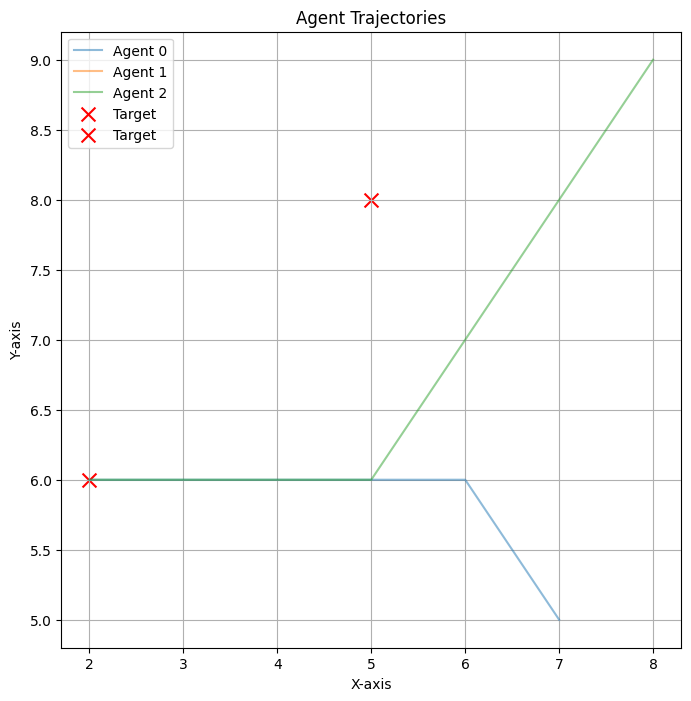

In [9]:
visualize_environment(multi_agent_env)